# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,no-author-rec,7609,10788
1,BX-I,no-author-rec,15129,28680
2,BX-E,no-book,20075,23084
3,BX-I,no-book,40633,56245
4,BX-E,male,56420,179708


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,236288.0,516914.0,21208.0,228337.0,160625.0,113652.0,985503.0,2262527.0
BX-E,39314.0,56420.0,5000.0,15144.0,7609.0,5613.0,20075.0,149175.0
BX-I,69258.0,98474.0,8575.0,31190.0,15129.0,11350.0,40633.0,274609.0
GR-E,212727.0,310493.0,15950.0,98431.0,60216.0,787097.0,NaN,1484914.0
GR-I,214784.0,314347.0,16119.0,100127.0,61305.0,799783.0,NaN,1506465.0
LOC-MDS,720587.0,2287800.0,67956.0,1028150.0,520642.0,609387.0,NaN,5234522.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4711169.0,6716541.0,756295.0,2008102.0,1171413.0,1278813.0,5798466.0
BX-E,141413.0,179708.0,40135.0,24467.0,10788.0,7614.0,23084.0
BX-I,398462.0,456126.0,100145.0,69134.0,28680.0,20420.0,56245.0
GR-E,36305140.0,33066403.0,12125257.0,3480996.0,1946913.0,12294989.0,NaN
GR-I,81974767.0,69098273.0,19895366.0,9688190.0,5611437.0,33273918.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.104435,0.228468,0.009374,0.100921,0.070994,0.050232,0.435576
BX-E,0.263543,0.378214,0.033518,0.101518,0.051007,0.037627,0.134573
BX-I,0.252206,0.358597,0.031226,0.113580,0.055093,0.041331,0.147967
GR-E,0.143259,0.209098,0.010741,0.066287,0.040552,0.530062,NaN
GR-I,0.142575,0.208665,0.010700,0.066465,0.040695,0.530900,NaN
LOC-MDS,0.137661,0.437060,0.012982,0.196417,0.099463,0.116417,NaN


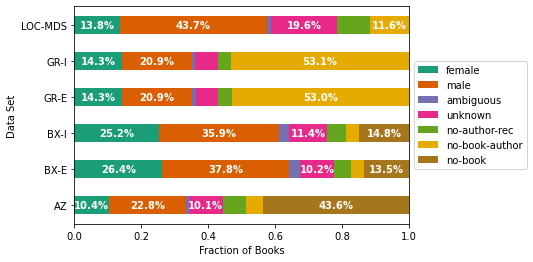

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.104435,0.228468,0.009374,0.100921,0.556802
BX-E,0.263543,0.378214,0.033518,0.101518,0.223208
BX-I,0.252206,0.358597,0.031226,0.113580,0.244391
GR-E,0.143259,0.209098,0.010741,0.066287,0.570614
GR-I,0.142575,0.208665,0.010700,0.066465,0.571595
LOC-MDS,0.137661,0.437060,0.012982,0.196417,0.215880


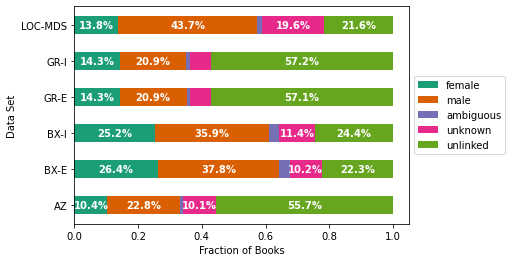

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

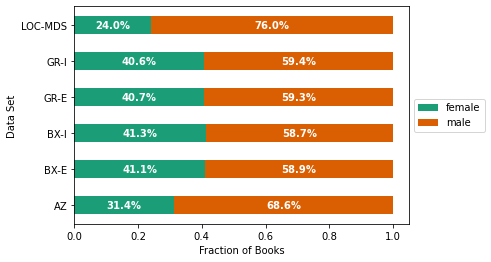

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.209938,0.299300,0.033702,0.089484,0.052200,0.056986,0.258389
BX-E,0.331016,0.420656,0.093947,0.057272,0.025252,0.017823,0.054034
BX-I,0.352867,0.403933,0.088686,0.061223,0.025398,0.018083,0.049809
GR-E,0.365907,0.333264,0.122206,0.035084,0.019622,0.123917,NaN
GR-I,0.373390,0.314738,0.090622,0.044129,0.025560,0.151561,NaN


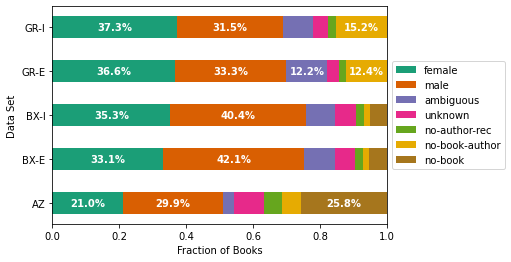

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.209938,0.299300,0.033702,0.089484,0.367576
BX-E,0.331016,0.420656,0.093947,0.057272,0.097109
BX-I,0.352867,0.403933,0.088686,0.061223,0.093291
GR-E,0.365907,0.333264,0.122206,0.035084,0.143539
GR-I,0.373390,0.314738,0.090622,0.044129,0.177120


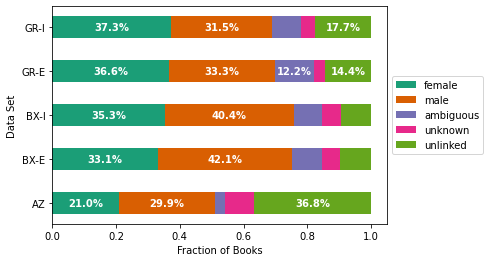

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

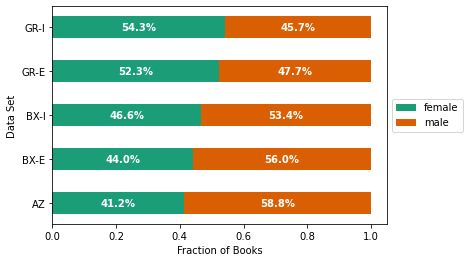

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.342277
BX-E       0.675274
BX-I       0.642029
GR-E       0.363098
GR-I       0.361940
LOC-MDS    0.587703
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')